In [7]:
import pandas as pd
import pytz
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

from pandas.plotting import scatter_matrix

# Analysis of Cycling Data

## Loading Data

This portfolio starts with an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `scripts/stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [1]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_convert(aus)
strava.head()

The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 



In [9]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

# Step 1
I combined two datasets to form a new dataset to use for analysis


In [139]:
new_dataset = strava.join(cheetah, how ='inner').dropna()
new_dataset.Datetimeindex = new_dataset["date"]
new_dataset.head()
new_dataset['date']



/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


2018-01-28 06:39:49+11:00    01/28/18
2018-01-28 07:01:32+11:00    01/28/18
2018-02-01 08:13:34+11:00    02/01/18
2018-02-06 08:06:42+11:00    02/06/18
2018-02-07 17:59:05+11:00    02/07/18
                               ...   
2019-07-13 06:18:22+10:00    07/13/19
2019-07-27 06:12:56+10:00    07/27/19
2019-07-28 06:42:59+10:00    07/28/19
2019-07-28 07:47:24+10:00    07/28/19
2019-07-28 09:55:13+10:00    07/28/19
Name: date, Length: 162, dtype: object

## Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
    
* Some of the rides are designated as "Race" in the `workout_type` field, these are where I am racing and you might expect that these would be the most challenging rides.  Normalised Power (NP) is a good measure of how hard a ride is.  Explore the values of `NP` for races vs the overall set of rides to see if this hypothesis is supported (use graphs and summary statistics).  Are races more challenging than rides in general? 





In [14]:
# new_dataset.drop(new_dataset[new_dataset.device_watts == 'False'].index, inplace=True)
# new_dataset

new_dataframe = new_dataset.query("device_watts == True")

new_dataframe = new_dataframe.reset_index(drop=True)

new_dataframe.head(5)



/Users/mac/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/Users/mac/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
0,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
1,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
3,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780
4,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride,...,0,0,0,0,0,0,0,212.726,0.79375,147.7970


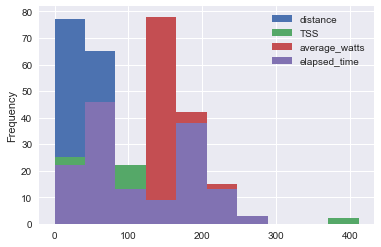

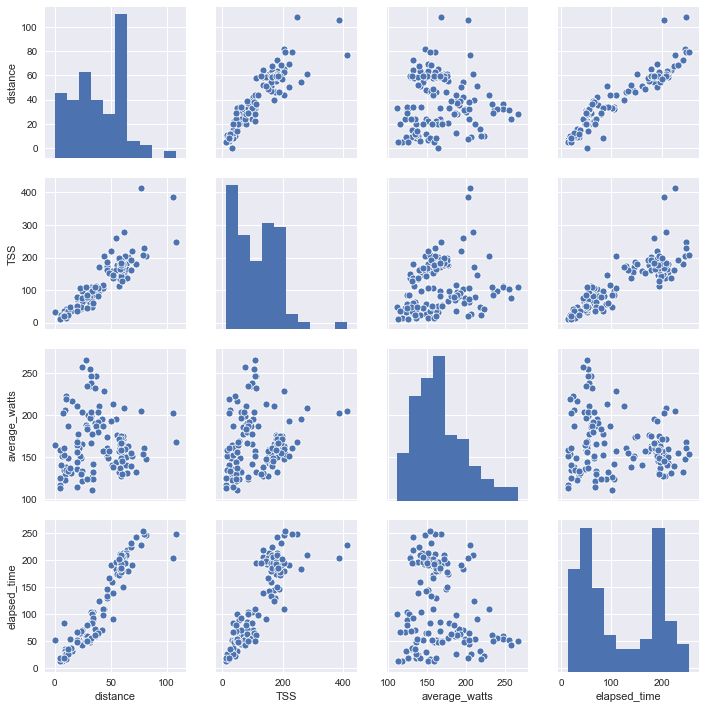

In [154]:
corr = new_dataframe[['time','distance', 'TSS', 'average_watts', 'elapsed_time']]
# new_dataframe.describe()
corr.plot(kind='hist', bins=10)
sns.pairplot(corr)
# plt.xlabel('elapsed_time')



Text(0.5,0,'distance')

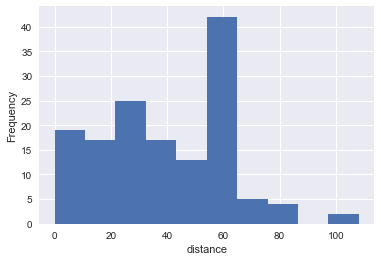

In [16]:
new_dataframe['distance'].plot(kind='hist', bins=10)
plt.xlabel('distance')

Text(0.5,0,'elapsed_time')

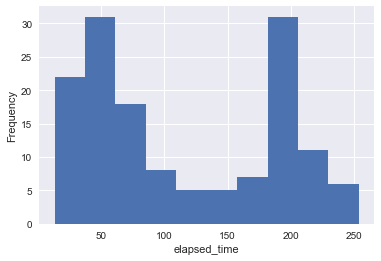

In [129]:
new_dataframe['elapsed_time'].plot(kind='hist', bins=10)
plt.xlabel('elapsed_time')

Text(0.5,0,'TSS')

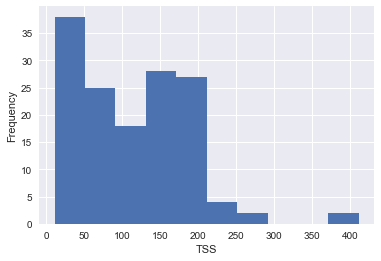

In [17]:
new_dataframe['TSS'].plot(kind='hist', bins=10)
plt.xlabel('TSS')

Text(0.5,0,'average_watts')

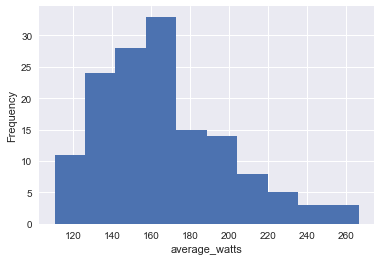

In [18]:
new_dataframe['average_watts'].plot(kind='hist', bins=10)
plt.xlabel('average_watts')

In [140]:
# correlation between columns
correlation = new_dataframe[['distance', 'moving_time', 'average_heartrate', 'NP', 'average_heartrate', 'Average Speed']]
correlation.head()

,distance,moving_time,average_heartrate,NP,average_heartrate,Average Speed
0,7.6,17,120.6,222.856,120.6,26.0234
1,38.6,67,146.9,245.365,146.9,34.4380
2,24.3,65,119.3,253.702,119.3,22.2417
3,47.1,134,124.8,232.644,124.8,20.7841
4,59.8,139,123.0,212.726,123.0,25.6585


In [141]:
correlation.corr(method ='pearson') 

,distance,moving_time,average_heartrate,NP,average_heartrate,Average Speed
distance,1.000000,0.968509,0.053572,0.156948,0.053572,0.034581
moving_time,0.968509,1.000000,-0.115809,0.030939,-0.115809,-0.191268
average_heartrate,0.053572,-0.115809,1.000000,0.595600,1.000000,0.752000
NP,0.156948,0.030939,0.595600,1.000000,0.595600,0.536113
average_heartrate,0.053572,-0.115809,1.000000,0.595600,1.000000,0.752000
Average Speed,0.034581,-0.191268,0.752000,0.536113,0.752000,1.000000


In [4]:
new_dataset.workout_type.unique()

In [23]:
df2= new_dataset[new_dataset['workout_type'].str.contains('Ride') & new_dataset['NP']] 
df2= df2.sample(26)

In [24]:
df3= new_dataset[new_dataset['workout_type'].str.contains('Race') & new_dataset['NP']] 
df3.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-10 20:46:02+00:00,152.1,19.0,198.9,True,31.0,49,387.00 m,21,49,Race,...,0,0,0,0,0,0,0,244.500,0.91231,69.2902
2018-03-03 20:02:23+00:00,143.0,18.0,217.3,True,15.5,32,175.00 m,15,28,Race,...,0,0,0,0,0,0,0,270.462,1.00919,47.6412
2018-03-24 20:45:44+00:00,153.6,16.0,200.2,True,30.1,50,381.00 m,16,50,Race,...,0,0,0,0,0,0,0,240.085,0.89584,67.9698
2018-04-07 21:47:39+00:00,141.8,17.0,223.7,True,10.0,23,130.00 m,11,22,Race,...,0,0,0,0,0,0,0,275.057,1.02633,41.5492


In [60]:
# selecting only workout type race and NP for graph
df2 = df2[['workout_type','NP']]
df2.head()

,workout_type,NP
2018-04-07 23:20:35+00:00,Ride,196.444
2019-05-03 20:19:49+00:00,Ride,239.786
2019-04-26 20:43:03+00:00,Ride,234.099
2019-06-07 20:22:42+00:00,Ride,226.844
2018-02-05 21:06:42+00:00,Ride,253.702


In [26]:
df1 = df3[['workout_type', 'NP']]
df1.head()

,workout_type,NP
2018-01-27 20:01:32+00:00,Race,245.365
2018-02-10 20:46:02+00:00,Race,244.500
2018-03-03 20:02:23+00:00,Race,270.462
2018-03-24 20:45:44+00:00,Race,240.085
2018-04-07 21:47:39+00:00,Race,275.057


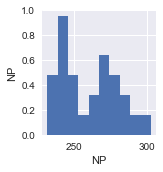

In [72]:
sns.pairplot(df1.loc[:,df1.dtypes == 'float64'])



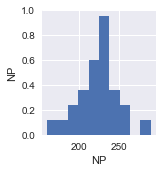

In [28]:
sns.pairplot(df2.loc[:,df2.dtypes == 'float64'])

In [81]:

df_ = pd.concat([df1,df2])
df_.head()


,workout_type,NP
2018-01-27 20:01:32+00:00,Race,245.365
2018-02-10 20:46:02+00:00,Race,244.500
2018-03-03 20:02:23+00:00,Race,270.462
2018-03-24 20:45:44+00:00,Race,240.085
2018-04-07 21:47:39+00:00,Race,275.057


In [82]:
#Statistical summary of both data sets
df = pd.merge(df1, df2, on='workout_type', how='outer')
df.describe()

,NP_x,NP_y
count,26.000000,26.000000
mean,259.947423,223.174462
std,19.430764,26.070601
min,231.614000,159.560000
25%,244.716250,211.125250
50%,257.292500,226.404000
75%,274.017250,236.671250
max,302.396000,289.382000


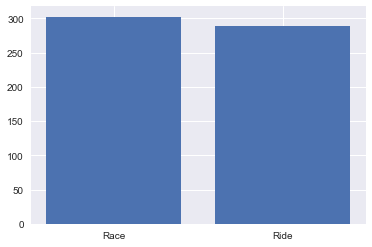

In [83]:
#graphical representation of workout types against NP

plt.bar(df_['workout_type'], df_['NP'])
plt.show()

In [143]:
final_dataset = new_dataset[['date','TSS', 'workout_type', 'Average Speed']]
final_dataset.head()

,date,TSS,workout_type,Average Speed
2018-01-28 06:39:49+11:00,01/28/18,20.2257,Ride,26.0234
2018-01-28 07:01:32+11:00,01/28/18,94.5787,Race,34.4380
2018-02-01 08:13:34+11:00,02/01/18,0.0000,Ride,13.6882
2018-02-06 08:06:42+11:00,02/06/18,98.3269,Ride,22.2417
2018-02-07 17:59:05+11:00,02/07/18,171.0780,Ride,20.7841


In [142]:
# div = new_dataset[['distance']].div(new_dataset.elapsed_time, axis=0)
# final_dataset['average_speed'] = div 
# final_dataset.head()

In [144]:
final_dataset.resample('M').sum()

,TSS,Average Speed
2018-01-31 00:00:00+11:00,114.8044,60.4614
2018-02-28 00:00:00+11:00,1035.4683,313.9593
2018-03-31 00:00:00+11:00,1345.6372,294.9035
2018-04-30 00:00:00+10:00,1232.1499,219.7050
2018-05-31 00:00:00+10:00,483.5867,141.8309
2018-06-30 00:00:00+10:00,586.4858,135.1855
2018-07-31 00:00:00+10:00,381.4320,70.5368
2018-08-31 00:00:00+10:00,242.4241,102.6941
2018-09-30 00:00:00+10:00,627.2077,119.8524
2018-10-31 00:00:00+11:00,554.9470,88.5391


In [145]:
final_dataset.resample('M').mean()

,TSS,Average Speed
2018-01-31 00:00:00+11:00,57.402200,30.230700
2018-02-28 00:00:00+11:00,79.651408,24.150715
2018-03-31 00:00:00+11:00,112.136433,24.575292
2018-04-30 00:00:00+10:00,136.905544,24.411667
2018-05-31 00:00:00+10:00,69.083814,20.261557
2018-06-30 00:00:00+10:00,117.297160,27.037100
2018-07-31 00:00:00+10:00,127.144000,23.512267
2018-08-31 00:00:00+10:00,40.404017,17.115683
2018-09-30 00:00:00+10:00,125.441540,23.970480
2018-10-31 00:00:00+11:00,138.736750,22.134775


## Challenge
 Built a visualisation to decide what leads to more kudos (this explains what indicates what rides are more popular).

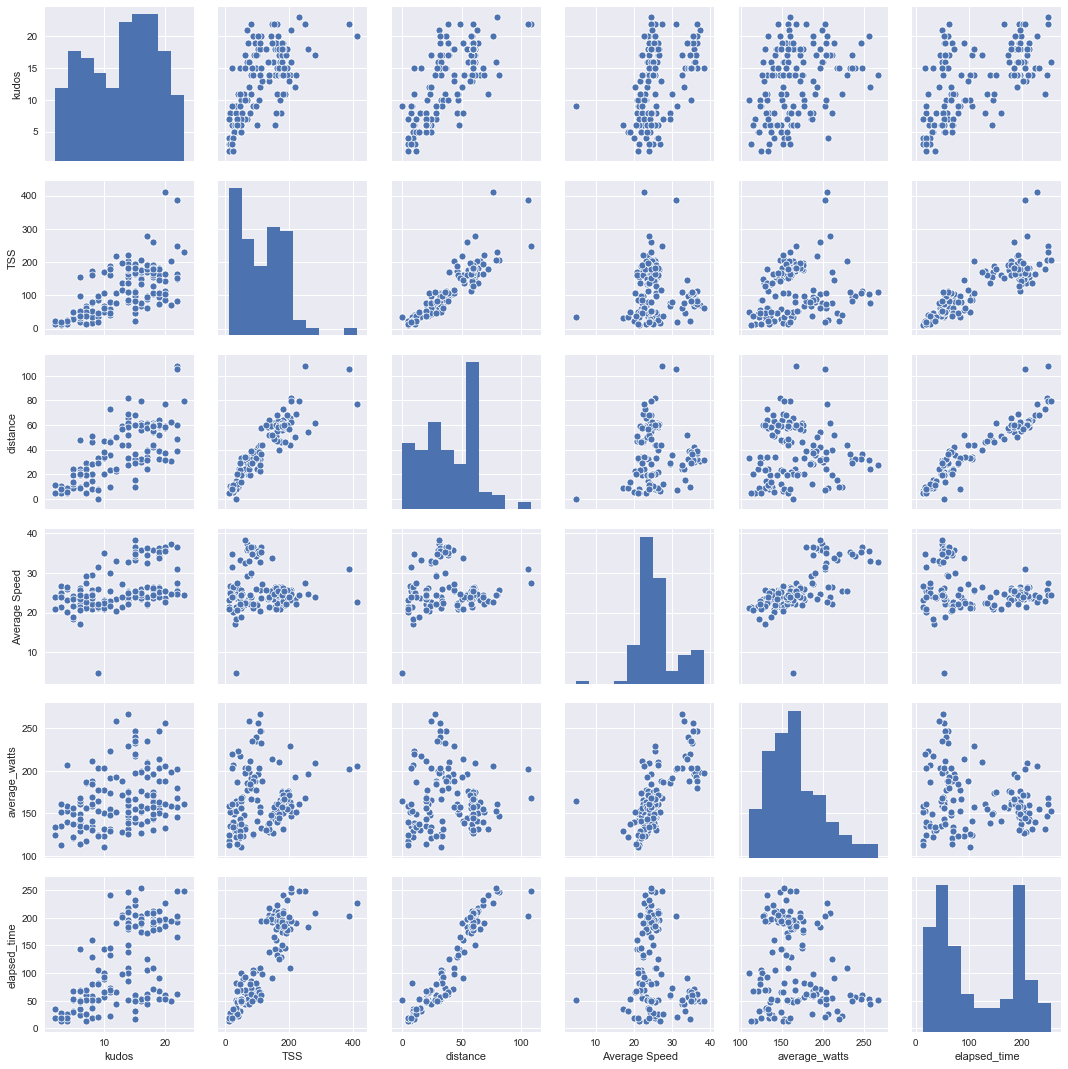

In [153]:
#Challenge
challenge_df = new_dataframe[['kudos', 'workout_type', 'TSS', 'distance', 'Average Speed','time', 'elevation_gain', 'average_watts', 'elapsed_time' ]]
challenge_df.sample(20)
# challenge_df.plot(kind='hist', bins=10)
challenge_df.corr(method ='pearson') 
sns.pairplot(challenge_df)


The correlation graph shows that all variables except average Speed inflences the increase in kudos

In [157]:
summary = new_dataset[['date','distance']]



In [158]:
summary.resample('M').sum()

,distance
2018-01-31 00:00:00+11:00,46.2
2018-02-28 00:00:00+11:00,459.0
2018-03-31 00:00:00+11:00,472.0
2018-04-30 00:00:00+10:00,423.6
2018-05-31 00:00:00+10:00,220.1
2018-06-30 00:00:00+10:00,193.4
2018-07-31 00:00:00+10:00,180.7
2018-08-31 00:00:00+10:00,113.5
2018-09-30 00:00:00+10:00,204.9
2018-10-31 00:00:00+11:00,217.6
